# Pythonで学ぶ制御工学 Part2

### 今日の目標
* 閉ループ系の安定性をPythonでチェックできる
* PID制御系の応答特性（時間・周波数）のグラフをPythonで描ける

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

## フィードバック系の安定性

$G_{yr}$ などのフィードバック系を求めてpoleで極を計算する

ただし， $G_{ud}$ はインプロパーになることがあり，伝達関数をPython上で記述できない場合がある

P と C の間に不安定な極零相殺がないばあいには，$G_{yr}$ の極を調べれば良い

In [2]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])

Gyr = feedback(P*C, 1)
print(Gyr.pole())

Gyd = -feedback(P*C, 1)
print(Gyd.pole())

Gur = minreal(P*feedback(1, P*C))
print(Gur.pole())

#Gud = C*feedback(1, P*C) #インプロパー
#print(Gud.pole())

[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]
[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]
2 states have been removed from the model
[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]


特性多項式を計算し，その根を求める

In [3]:
[[Np]], [[Dp]] = tfdata(P)
[[Nc]], [[Dc]] = tfdata(C)

f1 = np.poly1d(Np)
f2 = np.poly1d(Nc)
g1 = np.poly1d(Dp)
g2 = np.poly1d(Dc)

print(np.roots( f1*f2 + g1*g2 ))

[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]


## フィードバック系のステップ応答

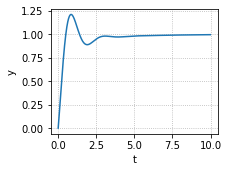

In [4]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])
Gyr = feedback(P*C, 1)

y,t = step(Gyr,np.arange(0, 10, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t,y)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.grid(ls=':')

ステップ応答の解析

In [5]:
Info = stepinfo(Gyr, SettlingTimeThreshold=0.05)
print(Info)

{'RiseTime': 0.38134794663607546, 'SettlingTime': 2.526430146464, 'SettlingMin': 0.8889281055929367, 'SettlingMax': 1.2108759926728154, 'Overshoot': 21.096814935683064, 'Undershoot': 0.0, 'Peak': 1.2108759926728154, 'PeakTime': 0.8580328799311698, 'SteadyStateValue': 0.9999238983419472}


In [8]:
print(type(Info))
# 辞書形式

<class 'dict'>


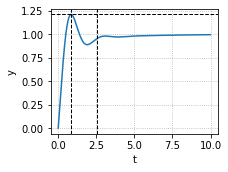

In [9]:
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t,y)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.axvline(Info['PeakTime'], lw=1, ls='--', c='k')
ax.axhline(Info['Peak'], lw=1, ls='--', c='k')
ax.axvline(Info['SettlingTime'], lw=1, ls='--', c='k')
ax.grid(ls=':')

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## フィードバック系の周波数特性

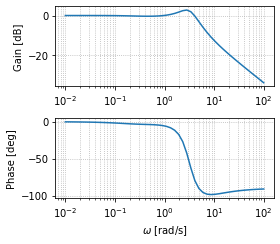

In [31]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])
Gyr = feedback(P*C, 1)

gain, phase, w = bode(Gyr, logspace(-2,2), Plot=False)

fig, ax = plt.subplots(2,1, figsize=(4, 3.5))
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
fig.tight_layout()

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

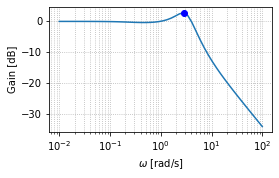

In [37]:
from scipy import signal

gain, phase, w = bode(Gyr, logspace(-2,2), Plot=False)

fig, ax = plt.subplots(figsize=(4, 2.3))
ax.semilogx(w, 20*np.log10(gain))

# ピークゲイン
[maxId] = signal.argrelmax(gain)
ax.plot(w[maxId], 20*np.log10(gain[maxId]), 'bo')

ax.set_ylabel('Gain [dB]')
ax.set_xlabel('$\omega$ [rad/s]')
ax.grid(which="both", ls=':')

## PIDゲインチューニング

### 限界感度法

In [11]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
m  = 0.5                 # アームの質量[kg]
c  = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

P = tf( [0,1], [J, c, m*g*l] )

ref = 30 # 目標角度 [deg]

無駄時間要素の追加

２次遅れ系はP制御では不安定にならない．
また，現実の制御対象には無駄時間がある

In [12]:
num_delay, den_delay = pade( 0.005, 1)
Pdelay = P * tf(num_delay, den_delay)
Pdelay


               -s + 400
--------------------------------------
0.01 s^3 + 4.015 s^2 + 6.981 s + 392.4

安定限界を調べる

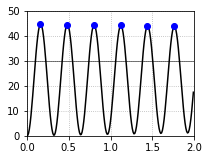

In [13]:
from scipy import signal

fig, ax = plt.subplots(figsize=(3, 2.3))

kp0 = 2.9
C = tf([0, kp0], [0, 1])
Gyr = feedback(Pdelay*C, 1)
y,t = step(Gyr, np.arange(0, 2, 0.01))

[maxId] = signal.argrelmax(y)

ax.plot(t, y*ref, color='k')
ax.plot(t[maxId], y[maxId]*ref, 'bo')

ax.axhline(ref, color='k', linewidth=0.5)    
ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
ax.grid(ls=':')

#fig.savefig("tune_zn.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

チューニング

In [15]:
kp = [0, 0]
ki = [0, 0]
kd = [0, 0]
Rule = ['', '']

T0 = t[maxId[1]]-t[maxId[0]]
print('T0=', T0)
print('kP0=', kp0)

# Classic ZN
Rule[0] = 'Classic'
kp[0] = 0.6 * kp0
ki[0] = kp[0] / (0.5 * T0)
kd[0] = kp[0] * (0.125 * T0)

# No overshoot
Rule[1] = 'No Overshoot'
kp[1] = 0.2 * kp0
ki[1] = kp[1] / (0.5 * T0)
kd[1] = kp[1] * (0.33 * T0)

T0= 0.31999999999999995
kP0= 2.9


Classic
kP= 1.74
kI= 10.875000000000002
kD= 0.0696
------------------
No Overshoot
kP= 0.58
kI= 3.6250000000000004
kD= 0.06124799999999999
------------------


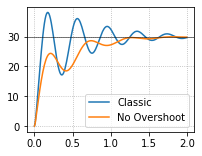

In [16]:
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(2):
    C = tf([kd[i], kp[i], ki[i]], [1, 0])
    Gyr = feedback(Pdelay*C, 1)
    y, t = step(Gyr, np.arange(0, 2, 0.01))
    
    ax.plot(t, y*ref, label=Rule[i])
    
    print(Rule[i])
    print('kP=', kp[i])
    print('kI=', ki[i])
    print('kD=', kd[i])
    print('------------------')

ax.axhline(ref, color="k", linewidth=0.5) 
ax.legend()
ax.grid(ls=':')

### ステップ応答法

In [17]:
# 台車系のモデル
a = 6.25
b = 4.36
P = tf([0, b], [1, a, 0])

y, t = step(P, np.arange(0, 1, 0.01))

# ある程度時間が経過したあとの応答を１次関数で近似する
yslice = y[40::]
tslice = t[40::]
p = np.polyfit(tslice, yslice, 1)
p

array([ 0.68493029, -0.10034948])

無定位系の応答を１次関数で近似する

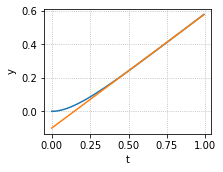

In [18]:
fig, ax = plt.subplots(figsize=(3, 2.3))
y, t = step(P, np.arange(0, 1, 0.01) )
ax.plot(t, y)
ax.plot(t, np.poly1d( p )(t))
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.grid(ls=':')

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

0.6849302927315275 0.14651050231691773


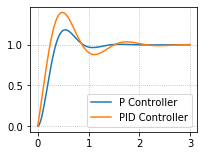

In [19]:
uref = 1
R = p[0]/uref
L = -p[1]/p[0]
print(R, L)

kp = [0, 0]
ki = [0, 0]
kd = [0, 0]
Rule = ['', '']

# P Controller
Rule[0] = 'P Controller'
kp[0] = 1/(R*L)

# PID Controller
Rule[1] = 'PID Controller'
kp[1] = 1.2/(R*L)
ki[1] = kp[1] / (2 * L)
kd[1] = kp[1] * (0.5 * L)

fig, ax = plt.subplots(figsize=(3, 2.3))
for i in range(2):
    C = tf([kd[i], kp[i], ki[i]], [1, 0])
    Gyr = feedback(P*C, 1)
    y, t = step(Gyr, np.arange(0, 3, 0.01))
    ax.plot(t, y, label=Rule[i])
    
ax.legend()
ax.grid(ls=':')

### モデルマッチング法

制御系設計の例題
* 定常偏差が生じない
* オーバーシュートが１０％以下
* 整定時間が0.5秒以下

In [20]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
m  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

ref = 30

P = tf( [0,1], [J, mu, m*g*l] )

In [27]:
import sympy as sp
s = sp.Symbol('s')
kp, kd, ki = sp.symbols('k_p k_d k_i')
mgl, c, J = sp.symbols('mgl c J')
sp.init_printing()

T = ki/(J*s**3 +(c+kd)*s**2 + (mgl + kp)*s + ki)
sp.series(1/T, s, 0, 4)

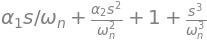

In [29]:
a1, a2, wn = sp.symbols('alpha_1, alpha_2, omega_n')
M = wn**3/(s**3 +a2*wn*s**2 + a1*wn**2*s + wn**3)
sp.series(1/M, s, 0, 4)

In [30]:
f1 = J/ki-1/wn**3
f2 = (c+kd)/ki-a2/wn**2
f3 = (kp+mgl)/ki - a1/wn
sp.solve([f1, f2, f3],[kp, kd, ki])

In [21]:
alpha1 = 2
alpha2 = 2
omega_n = 12

kp = J*alpha1*omega_n**2-m*g*l
ki = J*omega_n**3
kd = J*alpha2*omega_n - c

C1 = tf([kd, kp, ki], [1, 0])
C2 = tf([0, ki], [kd, kp, ki])

{'RiseTime': 0.19152485819152504,
 'SettlingTime': 0.4963296629963302,
 'SettlingMin': 0.9028806549649726,
 'SettlingMax': 1.0814649583429348,
 'Overshoot': 8.097897144500802,
 'Undershoot': 0.0,
 'Peak': 1.0814649583429348,
 'PeakTime': 0.40990990990991033,
 'SteadyStateValue': 1.0004495803440812}

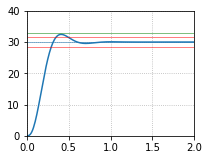

In [22]:
Gyz = feedback(P*C1, 1)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

#z, t, _ = lsim(C2, r, Td, 0)
#y, _, _ = lsim(Gyz, z, Td, 0)

fig, ax = plt.subplots(figsize=(3, 2.3))

y, t = step(Gyz*C2, Td)
ax.plot(t, y*ref, label='I-PD')

ax.axhline(ref, linewidth=0.5)
ax.axhline(ref*1.05, linewidth=0.5, c='r')  
ax.axhline(ref*0.95, linewidth=0.5, c='r')  
ax.axhline(ref*1.1, linewidth=0.5, c='g')  
ax.grid(ls=':')

ax.set_xlim(0, 2)
ax.set_ylim(0,40)

stepinfo(Gyz*C2, SettlingTimeThreshold=0.05)

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

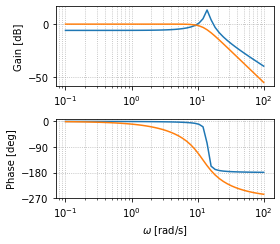

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P/(1+P), logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(C2*Gyz, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-270,-180,-90,0])

fig.tight_layout()

開ループ系の周波数特性

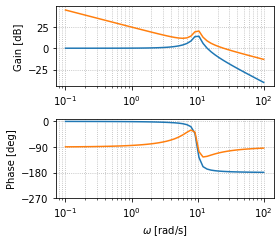

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(P*C1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-270,-180,-90,0])

fig.tight_layout()